# Normalização — Spotify Hits (v2)

Este notebook documenta **passo a passo** o processo de concatenação das abas `high` e `low`,
limpeza, engenharia de variáveis e normalização, preservando **`track_name`** e **`playlist_genre`**.

### Objetivos
1. Carregar e **concatenar** as abas `high_popularity_spotify_data` e `low_popularity_spotify_data`.
2. Criar o rótulo de origem **`is_hit`** (1 para high, 0 para low).
3. **Manter** `track_name`, `playlist_genre` e as features de áudio/contexto já usadas na v1.
4. Aplicar **capping** leve de outliers em `tempo`, `duration_ms`, `loudness`.
5. Calcular o **melhor limiar** em `track_popularity` e aplicar **tie-breaker** nos empates.
6. Montar um **pipeline de normalização**/codificação com `ColumnTransformer`.
7. Salvar artefatos (`Excel`, `CSV`, `Parquet*`) e gerar **gráficos** (distribuição de popularidade e taxa de hit por gênero).

> *Observação*: o Parquet depende de `pyarrow`/`fastparquet`. Se não estiver instalado, o passo será ignorado.


In [1]:
from __future__ import annotations
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from packaging import version
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Caminho padrão do Excel (ajuste conforme seu ambiente)
excel_path = r'D:\Previsor-de-Hits-IA\data\high_low_popularity_spotify_data.xlsx'
excel_path = os.environ.get('EXCEL_PATH', excel_path)
HIGH_SHEET = 'high_popularity_spotify_data'
LOW_SHEET  = 'low_popularity_spotify_data'

MAINSTREAM_GENRES = {'pop', 'hip-hop', 'latin'}  # usada no tie-breaker

print('Excel path:', excel_path)
print('sklearn:', sklearn.__version__)


Excel path: D:\Previsor-de-Hits-IA\data\high_low_popularity_spotify_data.xlsx
sklearn: 1.7.2


In [2]:
def best_threshold(y_true: np.ndarray, scores: np.ndarray) -> tuple[float, float]:
    """Busca o limiar que maximiza acurácia de (scores >= c). Retorna (c, acc)."""
    vals = np.unique(scores[~np.isnan(scores)])
    best_c, best_acc = None, -1.0
    for c in vals:
        y_pred = (scores >= c).astype(int)
        acc = (y_pred == y_true).mean()
        if acc > best_acc:
            best_acc, best_c = acc, float(c)
    return best_c, best_acc

def apply_tie_breaker(popularity: float, threshold: float, playlist_genre: str) -> int:
    """Resolve empates (popularity == threshold) usando playlist_genre.
    - Se gênero for mainstream -> 1 (hit), senão 0. Fora do empate: > c -> 1, < c -> 0.
    """
    if pd.isna(popularity):
        return 0
    if popularity > threshold:
        return 1
    if popularity < threshold:
        return 0
    pg = (playlist_genre or '').strip().lower()
    return 1 if pg in MAINSTREAM_GENRES else 0

def cap_outliers(df: pd.DataFrame, cols: list[str], lower: float = 0.01, upper: float = 0.99) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            lo, hi = df[c].quantile([lower, upper])
            df[c] = df[c].clip(lo, hi)
    return df


In [3]:
# Leitura das abas e criação do rótulo de origem (robusto: Excel ou CSV)
from pathlib import Path
import io, re

def read_csv_robust(path: Path):
    try:
        return pd.read_csv(path)
    except Exception:
        txt = Path(path).read_text(encoding='utf-8', errors='ignore')
        header_patterns = [r'(?:^|\n)time\_signature,track\_popularity,', r'(?:^|\n)energy,tempo,danceability,']
        start_idx = None
        for pat in header_patterns:
            m = re.search(pat, txt)
            if m:
                start_idx = m.start()
                break
        if start_idx is None:
            raise FileNotFoundError(f'Não foi possível localizar cabeçalho CSV em {path}')
        csv_txt = txt[start_idx:].strip()
        for tm in ['[This Output has been Truncated]', 'This Output has been Truncated']:
            pos = csv_txt.find(tm)
            if pos != -1:
                csv_txt = csv_txt[:pos]
        return pd.read_csv(io.StringIO(csv_txt))

excel_file = Path(excel_path)
data_dir = excel_file.parent if excel_file.parent.exists() else Path.cwd() / 'data'

if excel_file.exists():
    print('Lendo **Excel** com duas abas...')
    high = pd.read_excel(excel_file, sheet_name=HIGH_SHEET, engine='openpyxl')
    low  = pd.read_excel(excel_file, sheet_name=LOW_SHEET,  engine='openpyxl')
else:
    print('Excel não encontrado. Tentando **CSV** no diretório:', data_dir)
    high_csv = data_dir / 'high_popularity_spotify_data.csv'
    low_csv  = data_dir / 'low_popularity_spotify_data.csv'
    if not high_csv.exists() or not low_csv.exists():
        raise FileNotFoundError(f'Arquivos CSV não encontrados: {high_csv} ou {low_csv}')
    high = read_csv_robust(high_csv)
    low  = read_csv_robust(low_csv)

for df_ in (high, low):
    df_.columns = [str(c).strip() for c in df_.columns]
high['is_hit'] = 1
low['is_hit']  = 0

print('High shape:', high.shape, 'Low shape:', low.shape)
print('High cols:', list(high.columns)[:8], '...')


Excel não encontrado. Tentando **CSV** no diretório: D:\Previsor-de-Hits-IA\data
High shape: (1686, 30) Low shape: (3145, 30)
High cols: ['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness', 'liveness', 'valence', 'track_artist'] ...


### Limpeza e preservação de colunas
- **Convertendo data para ano** (release_year).
- **Removendo identificadores/URLs** e textos de alta cardinalidade, **mas mantendo** `track_name` e `playlist_genre`.
- Critérios alinhados à v1 para favorecer modelagem e explicabilidade.


In [4]:
TO_DROP = {'id','track_id','playlist_id','track_href','analysis_url','uri','track_album_id','type',
           'track_album_name','playlist_name','track_artist'}

for df in (high, low):
    if 'track_album_release_date' in df.columns:
        df['release_year'] = pd.to_datetime(df['track_album_release_date'], errors='coerce').dt.year

def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    drop_cols = [c for c in TO_DROP if c in df.columns]
    return df.drop(columns=drop_cols, errors='ignore')

high = drop_columns(high)
low  = drop_columns(low)

common_cols = sorted(set(high.columns).intersection(set(low.columns)))
df = pd.concat([high[common_cols], low[common_cols]], ignore_index=True)
before = df.shape[0]
df = df.drop_duplicates()
print('Duplicados removidos:', before - df.shape[0])
df.head(3)


Duplicados removidos: 0


,acousticness,danceability,duration_ms,energy,instrumentalness,is_hit,key,liveness,loudness,mode,playlist_genre,playlist_subgenre,release_year,speechiness,tempo,time_signature,track_album_release_date,track_name,track_popularity,valence
0,0.308,0.521,251668.0,0.592,0.0000,1,6.0,0.122,-7.777,0.0,pop,mainstream,2024.0,0.0304,157.969,3.0,2024-08-16,Die With A Smile,100,0.535
1,0.200,0.747,210373.0,0.507,0.0608,1,2.0,0.117,-10.171,1.0,pop,mainstream,2024.0,0.0358,104.978,4.0,2024-05-17,BIRDS OF A FEATHER,97,0.438
2,0.214,0.554,166300.0,0.808,0.0000,1,1.0,0.159,-4.169,1.0,pop,mainstream,2024.0,0.0368,108.548,4.0,2024-10-18,That’s So True,93,0.372


### Seleção de variáveis
- Numéricas em [0,1]: `danceability`, `energy`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`.
- Numéricas a escalar: `tempo`, `duration_ms`, `loudness`.
- Categóricas: `playlist_genre`, `playlist_subgenre`, `key`, `mode`, `time_signature`, `release_year`.
- Auxiliares: `track_name`, `playlist_genre`, `track_popularity`, `is_hit`.


In [5]:
num_01 = [c for c in ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence'] if c in df.columns]
num_scale = [c for c in ['tempo','duration_ms','loudness'] if c in df.columns]
cat_cols = [c for c in ['playlist_genre','playlist_subgenre','key','mode','time_signature','release_year'] if c in df.columns]
aux_keep = [c for c in ['track_name','playlist_genre','track_popularity','is_hit'] if c in df.columns]
print('Num [0,1]:', num_01)
print('Num a escalar:', num_scale)
print('Categóricas:', cat_cols)


Num [0,1]: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
Num a escalar: ['tempo', 'duration_ms', 'loudness']
Categóricas: ['playlist_genre', 'playlist_subgenre', 'key', 'mode', 'time_signature', 'release_year']


In [6]:
if num_scale:
    df = cap_outliers(df, num_scale)
df[num_scale].describe().T if num_scale else 'Sem colunas para capping'


,count,mean,std,min,25%,50%,75%,max
tempo,4830.0,118.232372,28.147585,65.91457,96.06300,118.0595,136.72350,188.60965
duration_ms,4830.0,204111.889613,66993.141371,88892.16000,159000.00000,194866.5000,233478.00000,491172.51000
loudness,4830.0,-9.263840,6.984307,-39.83788,-10.29775,-7.1910,-5.33675,-2.05032


### Baseline por limiar de `track_popularity` + tie-breaker
Calcula o melhor limiar (max acurácia). Em empates, usa `playlist_genre` ∈ {pop, hip-hop, latin} como desempate.


Melhor limiar: c=68.0 | acc=0.9907


Previsto (>= limiar),0,1
Real (is_hit),,
0,3100,45
1,0,1686


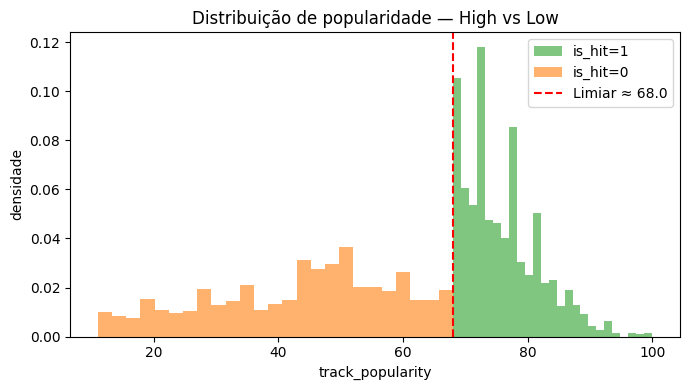

In [7]:
if 'track_popularity' in df.columns:
    df['track_popularity'] = pd.to_numeric(df['track_popularity'], errors='coerce')
    mask_valid = df['track_popularity'].notna()
    best_c, best_acc = best_threshold(df.loc[mask_valid, 'is_hit'].values, df.loc[mask_valid, 'track_popularity'].values)
    print(f'Melhor limiar: c={best_c} | acc={best_acc:.4f}')
    df['is_hit_rule'] = [apply_tie_breaker(p, best_c, g) if pd.notna(p) else np.nan
                         for p, g in zip(df['track_popularity'], df.get('playlist_genre', pd.Series(index=df.index))) ]
    df['is_hit_agree'] = np.where(df['is_hit_rule'].isna(), np.nan, (df['is_hit_rule'] == df['is_hit']).astype(int))
    # Matriz de confusão
    y_true = df.loc[mask_valid, 'is_hit'].values
    y_pred = (df.loc[mask_valid, 'track_popularity'] >= best_c).astype(int)
    cm = pd.crosstab(y_true, y_pred, rownames=['Real (is_hit)'], colnames=['Previsto (>= limiar)'])
    display(cm)
    # Plot distribuições
    plt.figure(figsize=(7,4))
    for label, color in [(1,'tab:green'),(0,'tab:orange')]:
        subset = df.loc[df.is_hit==label, 'track_popularity'].dropna()
        plt.hist(subset, bins=25, alpha=0.6, density=True, color=color, label=f'is_hit={label}')
    plt.axvline(best_c, color='red', linestyle='--', label=f'Limiar ≈ {best_c:.1f}')
    plt.xlabel('track_popularity'); plt.ylabel('densidade'); plt.title('Distribuição de popularidade — High vs Low')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print('Coluna track_popularity não disponível.')


### Pipeline de transformação
Imputações (mediana/frequente), `MinMaxScaler` (numéricas a escalar) e `OneHotEncoder` (`handle_unknown='ignore'`).


In [8]:
skver = version.parse(sklearn.__version__)
use_sparse_output = skver >= version.parse('1.2')
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) if use_sparse_output else OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_01_tf = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
numeric_scale_tf = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])
categorical_tf = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)])

preprocess = ColumnTransformer(transformers=[
    ('num01',   numeric_01_tf,   num_01),
    ('numscale',numeric_scale_tf, num_scale),
    ('cat',     categorical_tf,   cat_cols)
], remainder='drop')

# Saída como DataFrame quando possível
try:
    preprocess.set_output(transform='pandas')
    X_tr_df = preprocess.fit_transform(df[num_01 + num_scale + cat_cols])
except Exception:
    X_tr = preprocess.fit_transform(df[num_01 + num_scale + cat_cols])
    ohe_step = preprocess.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = list(ohe_step.get_feature_names_out(cat_cols))
    final_columns = num_01 + num_scale + cat_feature_names
    X_tr_df = pd.DataFrame(X_tr, columns=final_columns, index=df.index)

# Anexa auxiliares e rótulos
for col in aux_keep + ['is_hit_rule','is_hit_agree']:
    if col in df.columns and col not in X_tr_df.columns:
        X_tr_df[col] = df[col].values

# Garante que is_hit esteja ao fim
if 'is_hit' in X_tr_df.columns:
    cols = [c for c in X_tr_df.columns if c != 'is_hit'] + ['is_hit']
    X_tr_df = X_tr_df[cols]

X_tr_df.head()


,num01__danceability,num01__energy,num01__speechiness,num01__acousticness,num01__instrumentalness,num01__liveness,num01__valence,numscale__tempo,numscale__duration_ms,numscale__loudness,...,cat__release_year_2021.0,cat__release_year_2022.0,cat__release_year_2023.0,cat__release_year_2024.0,track_name,playlist_genre,track_popularity,is_hit_rule,is_hit_agree,is_hit
0,0.521,0.592,0.0304,0.3080,0.0000,0.122,0.535,0.750270,0.404633,0.848451,...,0.0,0.0,0.0,1.0,Die With A Smile,pop,100,1,1.0,1
1,0.747,0.507,0.0358,0.2000,0.0608,0.117,0.438,0.318378,0.301981,0.785096,...,0.0,0.0,0.0,1.0,BIRDS OF A FEATHER,pop,97,1,1.0,1
2,0.554,0.808,0.0368,0.2140,0.0000,0.159,0.372,0.347475,0.192423,0.943932,...,0.0,0.0,0.0,1.0,That’s So True,pop,93,1,1.0,1
3,0.670,0.910,0.0634,0.0939,0.0000,0.304,0.786,0.383483,0.170000,0.946552,...,0.0,0.0,0.0,1.0,Taste,pop,81,1,1.0,1
4,0.777,0.783,0.2600,0.0283,0.0000,0.355,0.939,0.677390,0.201414,0.935781,...,0.0,0.0,0.0,1.0,APT.,pop,98,1,1.0,1


### Visualização: taxa de hit por `playlist_genre`
Agrupamos por `playlist_genre` usando `is_hit` (rótulo de origem) e plotamos um gráfico de barras.


,n,hit_rate
playlist_genre,,
r&b,50,1.000000
gaming,133,0.751880
metal,49,0.714286
pop,515,0.693204
rock,345,0.681159
punk,74,0.675676
k-pop,17,0.647059
hip-hop,395,0.574684
blues,88,0.511364


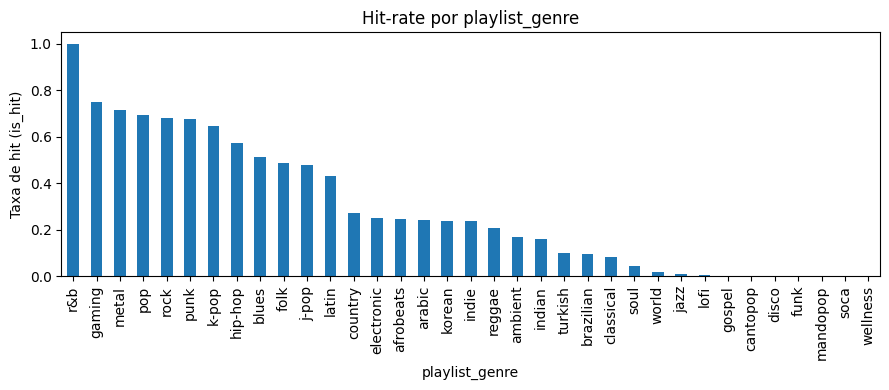

In [9]:
if 'playlist_genre' in X_tr_df.columns:
    genre_rate = (X_tr_df.groupby('playlist_genre')['is_hit']
                  .agg(['count','mean'])
                  .rename(columns={'count':'n','mean':'hit_rate'})
                  .sort_values('hit_rate', ascending=False))
    display(genre_rate.head(10))
    plt.figure(figsize=(9,4))
    genre_rate['hit_rate'].plot(kind='bar', color='tab:blue')
    plt.ylabel('Taxa de hit (is_hit)')
    plt.title('Hit-rate por playlist_genre')
    plt.tight_layout(); plt.show()
else:
    print('playlist_genre não disponível no dataset preparado.')


### Salvando artefatos
Geramos `Excel` (aba `prepared` + `genre_hit_rate`), `CSV` e tentamos `Parquet`.


In [11]:
out_dir = Path(r'D:\Previsor-de-Hits-IA\data\processed')
out_dir.mkdir(parents=True, exist_ok=True)

ts = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
excel_out = out_dir / f'spotify_prepared_v2_{ts}.xlsx'
csv_out   = out_dir / f'spotify_prepared_v2_{ts}.csv'
parq_out  = out_dir / f'spotify_prepared_v2_{ts}.parquet'
rate_out  = out_dir / f'spotify_genre_hit_rate_{ts}.csv'

with pd.ExcelWriter(excel_out, engine='openpyxl') as writer:
    X_tr_df.to_excel(writer, sheet_name='prepared', index=False)
    if 'playlist_genre' in X_tr_df.columns:
        genre_rate.to_excel(writer, sheet_name='genre_hit_rate')

X_tr_df.to_csv(csv_out, index=False)
if 'playlist_genre' in X_tr_df.columns:
    genre_rate.to_csv(rate_out)

try:
    X_tr_df.to_parquet(parq_out, index=False)
except Exception as e:
    print('Parquet não salvo (engine ausente):', e)

print('Excel:', excel_out)
print('CSV  :', csv_out)
print('Rate :', rate_out if 'playlist_genre' in X_tr_df.columns else 'não gerado')
print('Parquet:', parq_out)


Excel: D:\Previsor-de-Hits-IA\data\processed\spotify_prepared_v2_20251114_104521.xlsx
CSV  : D:\Previsor-de-Hits-IA\data\processed\spotify_prepared_v2_20251114_104521.csv
Rate : D:\Previsor-de-Hits-IA\data\processed\spotify_genre_hit_rate_20251114_104521.csv
Parquet: D:\Previsor-de-Hits-IA\data\processed\spotify_prepared_v2_20251114_104521.parquet


### Resumo
- Concatenação `high` + `low` com rótulo `is_hit`.
- Preservação de `track_name` e `playlist_genre` para gráficos e auditoria.
- Capping de outliers nas numéricas de escala livre.
- **Threshold ótimo** em `track_popularity` com **tie-breaker** por `playlist_genre`.
- Pipeline com imputações, `MinMaxScaler` e `OneHotEncoder`.
- Artefatos salvos (`prepared`, `genre_hit_rate`).
